# Streetcar Delay Prediction - Deep Learning - REFACTORED

GOAL: predict streetcar delays using a simple Keras model

Refactored to look at delays by hour by day by route

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

In [15]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# from sklearn.preprocessing import CategoricalEncoder

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import os
import math
from subprocess import check_output
import seaborn as sns

#model libraries


from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model


In [16]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode

testproportion = 0.2 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = True # switch to determine whether to save model
picklemodel = True # switch for code to allow pickling of Keras model
hctextmax = 7000
maxwords = 6000

targetthresh = 6.0
targetcontinuous = False # switch to determine whether target is continuous or 

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}

#time_of_day = {'overnight':[0,5],'morning_rush':[5,10],
 #             'midday':[10,15],'aft_rush':[15,19],'evening':[19,23]}
              


emptythresh = 6000
# to address imbalance in training data between zero (no delay) and 1 (delay occurred) in refactored, specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 45.878

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5
loss_func = "binary_crossentropy"
if targetcontinuous:
    output_activation = "linear"
else:
    output_activation = "hard_sigmoid"



In [17]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}
              

def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)
    
# def get_count()
# merged_data cols
# Report Date 	Route 	Location 	Min Delay 	Min Gap 	Direction 	Report Date Time 	year 	month 	daym 	hour
# result 2 cols: count 	date 	Route 	Direction 	hour           
            

In [18]:
print("tod on",time_of_day['overnight']['start'])

tod on 0


In [19]:
print("tod  0",get_time(0))
print("tod 5",get_time(23))

tod  0 overnight
tod 5 evening


In [20]:
# get the directory for that this notebook is in
rawpath = os.getcwd()
print("raw path is",rawpath)

raw path is /storage/manning/notebooks


In [21]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
# this code assumes you have copied to this directory all the XLS files from the source dataset: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da
path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
print("path is", path)

path is /storage/manning/data/


In [22]:
# constants for the streetcar problem
pickled_data_file = '20142018_0930.pkl'
pickled_dataframe = '2014_2018_df_cleaned_remove_bad_apr23.pkl'

# Ingest data <a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [23]:
# load list of valid routes and directions into dataframe
routedirection_frame = pd.read_csv(path+"routedirection.csv") 
routedirection_frame.tail()

,Route,Direction
51,511,s
52,511,b
53,512,e
54,512,w
55,512,b


In [24]:
file_name = path + pickled_dataframe
merged_data = pd.read_pickle(file_name)
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,dundas west stationt to broadview station,General Delay,7.0,14.0,w,4028,2016-01-01 00:00:00
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,roncesvalles to neville park,Mechanical,6.0,12.0,e,4242,2016-01-01 14:28:00


In [25]:
merged_data.shape

(56205, 11)

In [26]:
# define cols for year month day hour
# apar_ds["year"] = pd.DatetimeIndex(apar_ds['PMR_Open_Date']).year 
merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour
Report Date Time,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,dundas west stationt to broadview station,General Delay,7.0,14.0,w,4028,2016-01-01 00:00:00,2016,1,1,0
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00,2016,1,1,2
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00,2016,1,1,2
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00,2016,1,1,3
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,roncesvalles to neville park,Mechanical,6.0,12.0,e,4242,2016-01-01 14:28:00,2016,1,1,14


In [27]:
# define time of day column
merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
merged_data.head()

# add a special timeframe for weekends
# df['NewCol'] = df.apply(lambda x: segmentMatch(x['TimeCol'], x['ResponseCol']), axis=1)
# weekend_time(day, tod)
merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour,time_of_day
Report Date Time,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,dundas west stationt to broadview station,General Delay,7.0,14.0,w,4028,2016-01-01 00:00:00,2016,1,1,0,overnight
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00,2016,1,1,2,overnight
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00,2016,1,1,2,overnight
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00,2016,1,1,3,overnight
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,roncesvalles to neville park,Mechanical,6.0,12.0,e,4242,2016-01-01 14:28:00,2016,1,1,14,midday


In [28]:
merged_data['year'].value_counts()

2018    12011
2016    11908
2015    10876
2017     9890
2014     9340
2019     2180
Name: year, dtype: int64

In [29]:
# define target column
if targetcontinuous:
    # merged_data = merged_data.rename(columns = {'Min Delay':'target'})
    merged_data['target'] = merged_data['Min Delay']
else:
    # np.where(df['age']>=50, 'yes', 'no')
    merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
merged_data['target'].head()
    

Report Date Time
2016-01-01 00:00:00    1
2016-01-01 02:14:00    1
2016-01-01 02:22:00    1
2016-01-01 03:28:00    1
2016-01-01 14:28:00    1
Name: target, dtype: int64

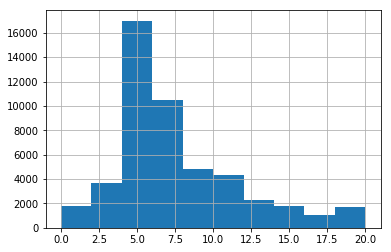

In [30]:
# merged_data['Min Delay'].hist(bins=2)
merged_data['Min Delay'].hist(range=(0,20))


In [31]:
# get data for refactored information
merged_data['Route'].value_counts()

501    14630
504    11811
506     7947
505     5576
512     4729
510     4221
511     2653
509     1856
502     1009
503      646
301      644
306      285
304      158
310       40
Name: Route, dtype: int64

In [32]:
merged_data.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour,time_of_day,target
Report Date Time,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,505,00:00:00,Friday,dundas west stationt to broadview station,General Delay,7.0,14.0,w,4028,2016-01-01 00:00:00,2016,1,1,0,overnight,1
2016-01-01 02:14:00,2016-01-01,511,02:14:00,Friday,fleet st. and strachan,Mechanical,10.0,20.0,e,4018,2016-01-01 02:14:00,2016,1,1,2,overnight,1
2016-01-01 02:22:00,2016-01-01,301,02:22:00,Friday,queen st. west and roncesvalles,Mechanical,9.0,18.0,w,4201,2016-01-01 02:22:00,2016,1,1,2,overnight,1
2016-01-01 03:28:00,2016-01-01,301,03:28:00,Friday,lake shore blvd. and superior st.,Mechanical,20.0,40.0,e,4251,2016-01-01 03:28:00,2016,1,1,3,overnight,1
2016-01-01 14:28:00,2016-01-01,501,14:28:00,Friday,roncesvalles to neville park,Mechanical,6.0,12.0,e,4242,2016-01-01 14:28:00,2016,1,1,14,midday,1


In [33]:
md_check = merged_data.groupby(['Report Date','hour','Route','Direction']).size().reset_index().rename(columns={0:'count_md'})

In [34]:
md_check.head(20)

,Report Date,hour,Route,Direction,count_md
0,2014-01-02,6,505,e,1
1,2014-01-02,12,504,e,1
2,2014-01-02,14,501,w,1
3,2014-01-02,14,504,w,1
4,2014-01-02,16,504,e,1
5,2014-01-02,17,501,w,1
6,2014-01-02,18,504,e,1
7,2014-01-02,19,510,s,1
8,2014-01-03,1,504,w,1
9,2014-01-03,5,501,w,2


In [35]:
md_check.tail(20)

,Report Date,hour,Route,Direction,count_md
48864,2019-02-28,7,504,e,1
48865,2019-02-28,7,504,w,1
48866,2019-02-28,7,510,n,1
48867,2019-02-28,9,501,w,1
48868,2019-02-28,9,504,e,1
48869,2019-02-28,10,506,e,2
48870,2019-02-28,11,501,e,1
48871,2019-02-28,11,506,e,3
48872,2019-02-28,12,501,w,1
48873,2019-02-28,12,506,e,2


In [36]:
#(df[education]=='9th').sum()
(md_check['count_md']==1).sum()

43381

In [37]:
(md_check['count_md']!=1).sum()

5503

In [38]:
md_check.shape

(48884, 5)

In [39]:
# df1.groupby(['A','B']).size().reset_index().rename(columns={0:'count'})
merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)

,Route,Direction,count
20,501,b,588
21,501,e,6961
22,501,n,85
23,501,s,107
24,501,w,6889
25,502,b,33
26,502,e,478
27,502,n,21
28,502,s,22
29,502,w,455


In [40]:
# REFACTORED DATAFRAME SHOULD HAVE THE FOLLOWING COLUMNS:
# DAY - for every day in the history from Jan 1 2014 to July 31 2018
# HOUR - for every hour of the day
#  for 501, regular route 5:00 am - midnight; 301 overnight
#   for 503: 7- 10:00 am; 4-7:00 pm
# for 504 5:00 am - 2:00 am; 304 overnight
# for 505 5:00 am - 1:00 am
# for 506 5:00 am - 1:00 am; 306 overnight
# for 509 5:00 am - 1:00 am
# for 510 5:00 am - 2:00 am; 310 overnight
# for 511 5:00 am - 1:00 am
# for 512 5:00 am - 2:00 am
# for 514 (Cherry street)
# ROUTE
# DIRECTION
# DELAY - where this could be count OR duration OR binary

# example of filling in values:
# data['PriceDate'] =  pd.to_datetime(data['PriceDate'], format='%m/%d/%Y')
# data = data.sort_values(by=['PriceDate'], ascending=[True])
# data.set_index('PriceDate', inplace=True)
# print (data)

# data = data.resample('D').ffill().reset_index()
# print (data)

In [41]:
routedirection_frame['count'] = 0
routedirection_frame.head()

,Route,Direction,count
0,301,e,0
1,301,w,0
2,301,b,0
3,304,e,0
4,304,e,0


In [42]:
# date_today = datetime.now()
# days = pd.date_range(date_today, date_today + timedelta(7), freq='D')
# check out:
# https://stackoverflow.com/questions/42941310/creating-pandas-dataframe-with-datetime-index-and-random-values-in-column/42941507
# https://stackoverflow.com/questions/47722552/pandas-set-datetime-timestamp-value-with-apply
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import date

date_today = datetime.now()
print("date today",date_today)
start_date =  date(2014, 1, 1)
print("start date",start_date)
end_date = date(2019, 2, 28)
print("end date",end_date)


date today 2019-07-07 22:53:12.815707
start date 2014-01-01
end date 2019-02-28


In [43]:
# create a dataframe with an index of days in the range
days = pd.date_range(start_date, end_date, freq='D')
print('days',days)

days DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22',
               '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26',
               '2019-02-27', '2019-02-28'],
              dtype='datetime64[ns]', length=1885, freq='D')


In [44]:
# df = pd.DataFrame({'test': days, 'col2': data})
date_frame = pd.DataFrame({'date':days,'count':0})
date_frame.head()

,date,count
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0


In [45]:
hour_list = list(range(0,24))
hour_frame = pd.DataFrame({'hour':hour_list,'count':0})
hour_frame.head(20)

,hour,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [46]:
# result = pd.merge(left, right, on='B', how='outer')
result1 = pd.merge(date_frame, routedirection_frame, on='count', how='outer')
result1.head()

,date,count,Route,Direction
0,2014-01-01,0,301,e
1,2014-01-01,0,301,w
2,2014-01-01,0,301,b
3,2014-01-01,0,304,e
4,2014-01-01,0,304,e


In [47]:
result1.tail()

,date,count,Route,Direction
105555,2019-02-28,0,511,s
105556,2019-02-28,0,511,b
105557,2019-02-28,0,512,e
105558,2019-02-28,0,512,w
105559,2019-02-28,0,512,b


In [48]:
result1.count()

date         105560
count        105560
Route        105560
Direction    105560
dtype: int64

In [49]:
result2 = pd.merge(result1, hour_frame, on='count', how='outer')
result2.head()

,date,count,Route,Direction,hour
0,2014-01-01,0,301,e,0
1,2014-01-01,0,301,e,1
2,2014-01-01,0,301,e,2
3,2014-01-01,0,301,e,3
4,2014-01-01,0,301,e,4


In [50]:
result2.head()

,date,count,Route,Direction,hour
0,2014-01-01,0,301,e,0
1,2014-01-01,0,301,e,1
2,2014-01-01,0,301,e,2
3,2014-01-01,0,301,e,3
4,2014-01-01,0,301,e,4


In [51]:
result2.count()

date         2533440
count        2533440
Route        2533440
Direction    2533440
hour         2533440
dtype: int64

In [52]:
# df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
result2 = result2.rename(columns={'date': 'Report Date'})
result2.head()

,Report Date,count,Route,Direction,hour
0,2014-01-01,0,301,e,0
1,2014-01-01,0,301,e,1
2,2014-01-01,0,301,e,2
3,2014-01-01,0,301,e,3
4,2014-01-01,0,301,e,4


In [53]:
result2.head()

,Report Date,count,Route,Direction,hour
0,2014-01-01,0,301,e,0
1,2014-01-01,0,301,e,1
2,2014-01-01,0,301,e,2
3,2014-01-01,0,301,e,3
4,2014-01-01,0,301,e,4


In [54]:
# correct Route type to match merged_data route type
result2.Route = result2.Route.astype(str)

In [55]:
result2['Route'].unique()

array(['301', '304', '306', '310', '501', '502', '503', '504', '505',
       '506', '509', '510', '511', '512'], dtype=object)

In [56]:
md_check['Route'].unique()

array(['505', '504', '501', '510', '511', '512', '502', '503', '506',
       '301', '509', '306', '304', '310'], dtype=object)

In [57]:
# segment the date
result2['year'] = pd.DatetimeIndex(result2['Report Date']).year
result2['month'] = pd.DatetimeIndex(result2['Report Date']).month
result2['daym'] = pd.DatetimeIndex(result2['Report Date']).day
result2['day'] = pd.DatetimeIndex(result2['Report Date']).weekday
result2.head()

,Report Date,count,Route,Direction,hour,year,month,daym,day
0,2014-01-01,0,301,e,0,2014,1,1,2
1,2014-01-01,0,301,e,1,2014,1,1,2
2,2014-01-01,0,301,e,2,2014,1,1,2
3,2014-01-01,0,301,e,3,2014,1,1,2
4,2014-01-01,0,301,e,4,2014,1,1,2


In [58]:
merged_data = merged_data.drop(['Time',
 'Report Date Time',
 'year',
 'month',
 'daym',
 'time_of_day','Min Gap','Location','Incident','Vehicle','target','Day'
                               ],axis=1)

In [59]:
merged_data.head()

,Report Date,Route,Min Delay,Direction,hour
Report Date Time,,,,,
2016-01-01 00:00:00,2016-01-01,505,7.0,w,0
2016-01-01 02:14:00,2016-01-01,511,10.0,e,2
2016-01-01 02:22:00,2016-01-01,301,9.0,w,2
2016-01-01 03:28:00,2016-01-01,301,20.0,e,3
2016-01-01 14:28:00,2016-01-01,501,6.0,e,14


In [60]:
result2.head()

,Report Date,count,Route,Direction,hour,year,month,daym,day
0,2014-01-01,0,301,e,0,2014,1,1,2
1,2014-01-01,0,301,e,1,2014,1,1,2
2,2014-01-01,0,301,e,2,2014,1,1,2
3,2014-01-01,0,301,e,3,2014,1,1,2
4,2014-01-01,0,301,e,4,2014,1,1,2


In [61]:
# join the refactored dataframe with the original dataframe to get superset dataframe

# result = pd.merge(left, right, how='left', on=['key1', 'key2'])
# result3 = pd.merge(result2,merged_data,how='left', on=['Report Date','Route','Direction','hour'])

# md_check
result3 = pd.merge(result2,merged_data ,how='left', on=['Report Date','Route','Direction','hour'])

# result3 = pd.merge(result2,merged_data,how='left', on=['Direction'])

# result3 = pd.merge(result2,merged_data,how='left', on=['Report Date','Route'])
#rr_bit = pd.merge(r_bit,m_bit,how='left', on=['Route'])
result3.head()

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay
0,2014-01-01,0,301,e,0,2014,1,1,2,NaN
1,2014-01-01,0,301,e,1,2014,1,1,2,NaN
2,2014-01-01,0,301,e,2,2014,1,1,2,NaN
3,2014-01-01,0,301,e,3,2014,1,1,2,NaN
4,2014-01-01,0,301,e,4,2014,1,1,2,NaN


In [62]:
result3.shape

(2540715, 10)

In [63]:
# get the number of non-NaN values in all columns
result3.count()

Report Date    2540715
count          2540715
Route          2540715
Direction      2540715
hour           2540715
year           2540715
month          2540715
daym           2540715
day            2540715
Min Delay        55680
dtype: int64

In [64]:
result3["Min Delay"].value_counts()

5.0      9091
4.0      7784
6.0      7511
10.0     3546
7.0      2922
8.0      2828
3.0      2536
9.0      1904
12.0     1588
2.0      1071
15.0     1070
1.0       904
0.0       802
11.0      769
20.0      759
14.0      683
13.0      660
18.0      580
16.0      570
17.0      492
30.0      454
19.0      389
25.0      385
22.0      382
21.0      373
23.0      349
24.0      342
26.0      296
28.0      262
27.0      259
         ... 
292.0       1
329.0       1
326.0       1
324.0       1
323.0       1
322.0       1
321.0       1
320.0       1
319.0       1
317.0       1
315.0       1
307.0       1
305.0       1
299.0       1
287.0       1
254.0       1
286.0       1
285.0       1
284.0       1
283.0       1
280.0       1
279.0       1
275.0       1
271.0       1
269.0       1
264.0       1
262.0       1
257.0       1
255.0       1
510.0       1
Name: Min Delay, Length: 339, dtype: int64

In [65]:
result3['count'].value_counts()

0    2540715
Name: count, dtype: int64

In [66]:
result3['Min Delay'].value_counts()

5.0      9091
4.0      7784
6.0      7511
10.0     3546
7.0      2922
8.0      2828
3.0      2536
9.0      1904
12.0     1588
2.0      1071
15.0     1070
1.0       904
0.0       802
11.0      769
20.0      759
14.0      683
13.0      660
18.0      580
16.0      570
17.0      492
30.0      454
19.0      389
25.0      385
22.0      382
21.0      373
23.0      349
24.0      342
26.0      296
28.0      262
27.0      259
         ... 
292.0       1
329.0       1
326.0       1
324.0       1
323.0       1
322.0       1
321.0       1
320.0       1
319.0       1
317.0       1
315.0       1
307.0       1
305.0       1
299.0       1
287.0       1
254.0       1
286.0       1
285.0       1
284.0       1
283.0       1
280.0       1
279.0       1
275.0       1
271.0       1
269.0       1
264.0       1
262.0       1
257.0       1
255.0       1
510.0       1
Name: Min Delay, Length: 339, dtype: int64

In [67]:
result3['Min Delay'].fillna(value=0.0,inplace=True)

In [68]:
result3.head()

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0


In [69]:
list(result3)

['Report Date',
 'count',
 'Route',
 'Direction',
 'hour',
 'year',
 'month',
 'daym',
 'day',
 'Min Delay']

In [70]:
merged_data = result3
# experiment with target defined by whether any Min Delay
merged_data['target'] = np.where(merged_data['Min Delay'] > 0.0, 1, 0 )
merged_data.head()

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0,0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0,0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0,0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0,0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0,0


In [71]:
merged_data['target'].value_counts()

0    2485837
1      54878
Name: target, dtype: int64

In [72]:
# df[(df['A']>0) & (df['B']>0) & (df['C']>0)].count()
merged_data[merged_data['target'] > 0].count()

Report Date    54878
count          54878
Route          54878
Direction      54878
hour           54878
year           54878
month          54878
daym           54878
day            54878
Min Delay      54878
target         54878
dtype: int64

# Define test / training sets;  encode categorical values; process text field

In [73]:
# get training and test data set

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)



Through train test split. Test proportion:
0.2


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [74]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'count', 'Route', 'Direction', 'hour', 'year', 'month', 'daym', 'day', 'Min Delay', 'target']


In [75]:
# define the required column lists

textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
continuouscols = [] # columns to deal with as continuous values - no embeddings
if targetcontinuous:
    excludefromcolist = ['count','Report Date', 'target','count_md','Min Delay'] # columns to exclude completely from the model
    
else:
    # if target column is not renamed Min Delay put Min Delay in exclusion list
    excludefromcolist = ['count','Report Date', 'target','count_md', 'Min Delay'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 11
excludefromcolist 5
['count', 'Report Date', 'target', 'count_md', 'Min Delay']
textcols 0
[]
continuouscols 0
[]
collist 7
['year', 'Direction', 'month', 'hour', 'day', 'Route', 'daym']


In [76]:
# ensure continuous columns have numeric type
for col in continuouscols:
    print("col is",col)
    merged_data[col] = merged_data[col].astype(float)
    print("got through one")
    superset_data[col] = superset_data[col].astype(float)

In [77]:
merged_data.dtypes

Report Date    datetime64[ns]
count                   int64
Route                  object
Direction              object
hour                    int64
year                    int64
month                   int64
daym                    int64
day                     int64
Min Delay             float64
target                  int64
dtype: object

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [78]:
# fill missing values

def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)





In [79]:
# process categorical data
# replace values with category IDs in the categorical columns
# 


lelist = {}

for col in collist:
    le = LabelEncoder()
    if verboseout:
        print("processing ",col)
    # fit on superset to ensure encoding includes future data but only model on past data
    # np.hstack([superset_data[col]])
    le.fit(np.hstack([merged_data[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    lelist[col] = le
    del le
    
    
train.head(5)
    

processing  year


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


processing  Direction
processing  month
processing  hour
processing  day
processing  Route
processing  daym


,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
1931133,2017-12-04,0,2,4,1,3,11,3,0,0.0,0
1689736,2017-06-07,0,11,1,5,3,5,6,2,0.0,0
2216597,2018-07-03,0,10,1,10,4,6,2,1,0.0,0
1995254,2018-01-20,0,9,2,0,4,0,19,5,0.0,0
285424,2014-07-31,0,12,1,7,0,6,30,3,0.0,0


In [80]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=maxwords,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    


In [81]:
# define max values for embeddings


max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



textmax 7000
max_dict {'year': 6, 'Direction': 5, 'month': 12, 'hour': 24, 'day': 7, 'Route': 14, 'daym': 31}


# Split training set into train / validate

In [82]:
# define and scale target and get validation sets

dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head()

    




/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1626057, 11)
(406515, 11)


In [83]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
       
    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))
        
    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))
        
    return X, dictlist

def get_keras_list_only(X_in):
    dictlist = []
    for key, value in X_in.items():
        print("X def loop key",key)
        print("value shape",value.shape)
        temp = [key,value]
        dictlist.append(value)
    return dictlist

def get_keras_np(X_in):
    return np.array(list(X_in.items()),dtype=object)
# np.array(list(result.items()), dtype=dtype)

# the deployment API for Watson Studio can only take a list/array, not a dictionary, so define list-only version for input
X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)
print("keras variables defined")
print("X_train_list",X_train_list)





cat col is year
cat col is Direction
cat col is month
cat col is hour
cat col is day
cat col is Route
cat col is daym
cat col is year
cat col is Direction
cat col is month
cat col is hour
cat col is day
cat col is Route
cat col is daym
cat col is year
cat col is Direction
cat col is month
cat col is hour
cat col is day
cat col is Route
cat col is daym
keras variables defined
X_train_list [array([3, 2, 0, ..., 3, 3, 0]), array([4, 1, 0, ..., 0, 2, 0]), array([10,  1,  4, ..., 10,  8,  8]), array([10,  4,  4, ..., 19,  4, 14]), array([6, 3, 1, ..., 5, 5, 6]), array([10,  5,  7, ...,  5, 12,  2]), array([11, 17, 26, ..., 17, 15, 27])]


# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [84]:
# define model in Keras

def get_model():
    
          
    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings
    
      
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    
    
    # define layers for text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        
    # define layers for continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
              
    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
       
    
    # define output layer
    output = Dense(1, activation=output_activation) (main_l)
   
    # define model        
                                                  
    model = Model(inputlayerlist, output)
    
       
    # define optimizer
    optimizer = SGD(lr=learning_rate)
   
    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
         
    
    return model

    
model = get_model()

#plot_model(model, to_file='/home/paperspace/visualizations/streetcarmodel_dec16.png', show_shapes=True, show_layer_names=True)

# output model summary

model.summary()
    

    

about to define embeddings
textmax is 7000
Instructions for updating:
Colocations handled automatically by placer.
through loops for cols
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
through definition of non-text parts of main_l
main_l Tensor("concatenate_6/concat:0", shape=(?, ?), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
year (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Direction (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None

In [85]:
BATCH_SIZE = 1000
# 200
epochs = 20
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",BATCH_SIZE)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)


model = get_model()
modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols []
dropout  0.0003
L2 lambda  0.0003
batch size  1000
epochs 20
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
about to define embeddings
textmax is 7000
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_12/concat:0", shape=(?, ?), dtype=float32)
Instructions for updating:
Use tf.cast instead.
Train on 1626057 samples, validate on 406515 samples
Epoch 1/20
1626057/1626057 [==============================] - 18s 11us/step - loss: 1.0508 - acc: 0.6267 - weighted_acc: 1.4401 - val_loss: 0.5629 - val_acc: 0.6911 - val_weighted_acc: 0.6911
Epoch 2/20
1626057/1626057 [==============================] - 16s 10us/step - loss: 1.0956 - acc: 0.7045 - weighted_acc: 1.4694 - val_loss: 0.5433 - val_acc: 0.7015 - val_weighted_acc: 0.7015
Epoch 3/20
1626057/1626057 [==============================] - 16s 10us/step - loss: 1.0263 - acc: 0.7167 - weighted_acc: 1.4905 - val_loss: 0.5241 - val_acc: 0.7216

In [86]:
modifier = "jul7h"
if savemodel == True:
    model_json = model.to_json()
    with open(path+'models/'+'model'+modifier+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(path+'models/'+'scweights'+modifier+'.h5')
    
    # save tokenizer tok_raw for text and label encoder for categorical cols
    
      
    model.save(path+'models/'+'scmodel'+modifier+'.h5')
    print("Saved model, weights, tokenizer and label encoder to disk")


Saved model, weights, tokenizer and label encoder to disk


In [87]:
!pwd

/storage/manning/notebooks


In [88]:
path

'/storage/manning/data/'

# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [89]:
from keras.models import load_model
loaded_model = load_model(path+'models/'+'scmodel'+modifier+'.h5')

In [90]:
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
year (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Direction (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 10)        60          year[0][0]                       
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 10)        50          Direction[0][0]                  
__________________________________________________________________________________________________
month (Inp

In [91]:
if presaved == True:
    BATCH_SIZE = 1000
    epochs = 1
    modelfit2 = loaded_model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid_list, dvalid.target), verbose=1)

# Predictions and renderings

In [92]:
# functions to parse and manipulate dates in the style of the input CSVs
import datetime
from datetime import date
def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [93]:
# predictions on training set

preds = model.predict(X_train, batch_size=BATCH_SIZE)

In [94]:
len(lelist)

7

In [95]:
preds.shape

(1626057, 1)

In [96]:
preds[:50]

array([[0.41791043],
       [0.16777125],
       [0.27947256],
       [0.3261026 ],
       [0.        ],
       [0.34880537],
       [0.6198254 ],
       [0.5946711 ],
       [0.6505012 ],
       [0.        ],
       [0.07573012],
       [0.        ],
       [0.06233051],
       [0.        ],
       [0.53452885],
       [0.33684006],
       [0.54175   ],
       [0.74765843],
       [0.24278125],
       [0.13849887],
       [0.10416007],
       [0.69090027],
       [0.        ],
       [0.61260635],
       [0.30015087],
       [0.00910658],
       [0.        ],
       [0.10212803],
       [0.        ],
       [0.        ],
       [0.4786086 ],
       [0.36988574],
       [0.45689434],
       [0.5850123 ],
       [0.05596876],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.1584548 ],
       [0.5818119 ],
       [0.35362086],
       [0.        ],
       [0.        ],
       [0.04677972],
       [0.        ],
       [0.34913355],
       [0.38058895],
       [0.   

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


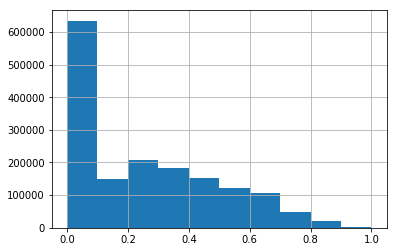

In [97]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

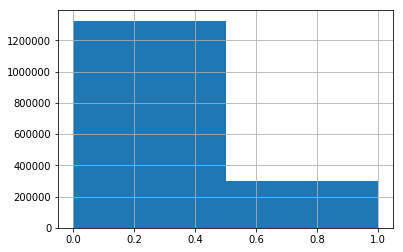

In [98]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [99]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

<class 'numpy.ndarray'>
(1626057, 1)
<class 'pandas.core.series.Series'>


In [100]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1902243    0
1048806    0
197312     0
1814296    0
2485474    0
Name: predround, dtype: int64

In [101]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



18662
percentage correct train
0.81338


In [102]:
# predict values for validation X values
# X_valid, dvalid.target
predval = model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


2252426    0.000000
2423692    0.000000
1679997    0.531485
2202143    0.686014
1111969    0.155230
Name: predict, dtype: float32

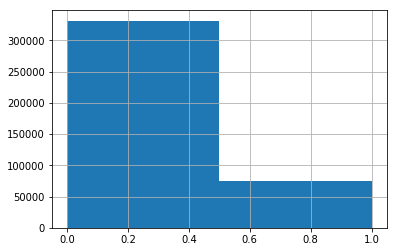

In [103]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [104]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


2252426    0
2423692    0
1679997    1
2202143    1
1111969    0
1762078    0
394492     0
176899     0
1139687    1
317615     0
Name: deltaval, dtype: int64
76521


/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predround,predict,deltaval
1679997,2017-05-31,0,8,4,21,3,4,30,2,0.0,0,1,0.531485,1
2202143,2018-06-22,0,13,4,11,4,5,21,4,0.0,0,1,0.686014,1
1139687,2016-04-25,0,8,4,8,2,3,24,0,0.0,0,1,0.641821,1
2299242,2018-09-02,0,13,4,3,4,8,1,6,0.0,0,1,0.514583,1
1034712,2016-02-07,0,12,4,11,2,1,6,6,0.0,0,1,0.504122,1
1991409,2018-01-17,0,11,1,7,4,0,16,2,0.0,0,1,0.710346,1
997866,2016-01-11,0,9,1,9,2,0,10,0,0.0,0,1,0.688004,1
557110,2015-02-18,0,7,1,22,1,1,17,2,0.0,0,1,0.707344,1
967372,2015-12-19,0,13,4,8,1,11,18,5,0.0,0,1,0.742810,1
2200333,2018-06-21,0,9,2,5,4,5,20,3,0.0,0,1,0.622875,1


In [106]:
dvalidright.head(20)

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target,predround,predict,deltaval
2252426,2018-07-30,0,4,4,6,4,6,29,0,0.0,0,0,0.000000,0
2423692,2018-12-04,0,4,1,18,4,11,3,1,0.0,0,0,0.000000,0
1111969,2016-04-05,0,0,1,1,2,3,4,1,0.0,0,0,0.155230,0
1762078,2017-07-31,0,8,2,2,3,6,30,0,0.0,0,0,0.217401,0
394492,2014-10-20,0,10,0,16,0,9,19,0,0.0,0,0,0.052722,0
176899,2014-05-12,0,5,4,0,0,4,11,0,0.0,0,0,0.072413,0
317615,2014-08-24,0,10,0,20,0,7,23,6,0.0,0,0,0.000000,0
995229,2016-01-09,0,9,3,1,2,0,8,5,0.0,0,0,0.000000,0
2469542,2019-01-07,0,4,0,20,5,0,6,0,0.0,0,0,0.000000,0
1894761,2017-11-07,0,2,1,3,3,10,6,1,0.0,0,0,0.085653,0


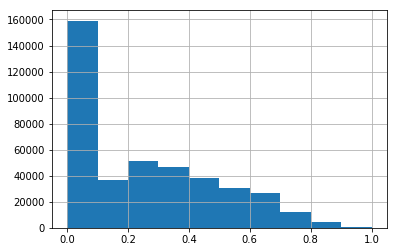

In [107]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [108]:
# ,encoding = "ISO-8859-1"
'''if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')'''

"if dsxmode == False:\n    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')"

In [109]:
dtrain.target[:50]

1902243    0
1048806    0
197312     0
1814296    0
2485474    0
990066     0
752638     0
1381212    0
1270472    0
589104     0
1147166    0
263083     0
906485     0
2089032    0
508935     0
537198     0
2486008    0
2293380    0
759458     0
1176836    0
854390     0
2165554    0
947537     0
1192151    0
294906     0
1017599    0
2274071    0
1299437    0
466279     0
2064910    0
1168312    0
2277764    0
2291833    0
757281     0
1741661    0
2291582    1
2063656    0
2371104    0
385494     0
1415985    0
1297941    0
1562242    0
2076115    0
2212905    0
1068904    0
1378564    0
549102     0
2049246    0
1780371    0
1243013    0
Name: target, dtype: int64

In [110]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


18824
percentage correct validate
0.81176


dict_keys(['val_loss', 'val_acc', 'val_weighted_acc', 'loss', 'acc', 'weighted_acc'])


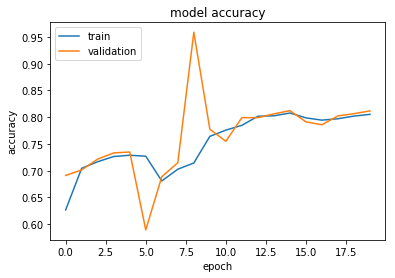

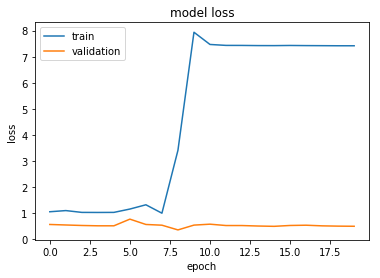

In [111]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

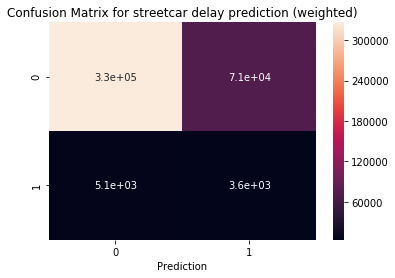

In [112]:
from sklearn import metrics

cfmap=metrics.confusion_matrix(y_true=dvalid['target'],  # True labels
                         y_pred=dvalid["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction (weighted)")
plt.show()

In [113]:
model.metrics_names

['loss', 'acc', 'weighted_acc']

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.